# Predictive Modeling

"A Two Stage Model for Predicting Winners in MLB" Yang and Swartz

In [1]:
import math
from math import e

import statistics

import pymc3 as pm

import numpy as np
from numpy import random

import pandas as pd
import pymc3 as pm

import scipy as sc
from scipy.stats import uniform, bernoulli, beta, expon, gamma, mannwhitneyu

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,5)

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

## Getting the Data

In order to be able to run the model, we'll need 3 statistics:
1. Earned Run Average (ERA), for home and away.
2. Winning percent ratio
3. Team batting average

All stats except the ERA stats were downloaded from baseball-reference.com. The ERA, split for Home and Away, was gathered from fangraphs.

### Earned Running Average

In [2]:
pitching_2014h = pd.read_csv('2014_ERA_Home.csv')
pitching_2014a = pd.read_csv('2014_ERA_Away.csv')

pitching_2015h = pd.read_csv('2015_ERA_Home.csv')
pitching_2015a = pd.read_csv('2015_ERA_Away.csv')

pitching_2016h = pd.read_csv('2016_ERA_Home.csv')
pitching_2016a = pd.read_csv('2016_ERA_Away.csv')

pitching_2017h= pd.read_csv('2017_ERA_Home.csv')
pitching_2017a = pd.read_csv('2017_ERA_Away.csv')

In [3]:
ERA_2014 = pd.DataFrame()
ERA_2015 = pd.DataFrame()
ERA_2016 = pd.DataFrame()
ERA_2017 = pd.DataFrame()

ERA_2014['Team'] = pitching_2014h['Team']
ERA_2014['ERA_Home'] = pitching_2014h['ERA']
ERA_2014['ERA_Away'] = pitching_2014a['ERA']

ERA_2015['Team'] = pitching_2015h['Team']
ERA_2015['ERA_Home'] = pitching_2015h['ERA']
ERA_2015['ERA_Away'] = pitching_2015a['ERA']

ERA_2016['Team'] = pitching_2016h['Team']
ERA_2016['ERA_Home'] = pitching_2016h['ERA']
ERA_2016['ERA_Away'] = pitching_2016a['ERA']

ERA_2017['Team'] = pitching_2017h['Team']
ERA_2017['ERA_Home'] = pitching_2017h['ERA']
ERA_2017['ERA_Away'] = pitching_2017a['ERA']

In [4]:
# Replacing Team name with their abbreviations
era_list = [ERA_2014, ERA_2015, ERA_2016, ERA_2017]
team_names = ['Angels', 'Astros', 'Athletics', 'Blue Jays', 'Braves', 'Brewers', 'Cardinals', 'Cubs', 'Diamondbacks', 'Dodgers', 'Giants', 'Indians', 'Mariners', 'Marlins', 'Mets', 'Nationals', 'Orioles', 'Padres', 'Phillies', 'Pirates', 'Rangers', 'Rays', 'Red Sox', 'Reds', 'Rockies', 'Royals', 'Tigers', 'Twins', 'White Sox', 'Yankees']
team_abvr = ['LAA', 'HOU', 'OAK', 'TOR', 'ATL', 'MIL', 'STL', 'CHC', 'ARI', 'LAD', 'SFG', 'CLE', 'SEA', 'MIA', 'NYM', 'WSN', 'BAL', 'SDP', 'PHI', 'PIT', 'TEX', 'TBR', 'BOS', 'CIN', 'COL', 'KCR', 'DET', 'MIN', 'CHW', 'NYY']

for dataframe in era_list:
    dataframe.replace(team_names, team_abvr, inplace=True)

In [5]:
for df in era_list:
    df.sort_values('Team', inplace=True)
ERA_2014 = ERA_2014.reset_index(drop=True)
ERA_2015 = ERA_2015.reset_index(drop=True)
ERA_2016 = ERA_2016.reset_index(drop=True)
ERA_2017 = ERA_2017.reset_index(drop=True)

In [6]:
ERA_2017

,Team,ERA_Home,ERA_Away
0,ARI,3.79,3.55
1,ATL,4.82,4.62
2,BAL,4.60,5.38
3,BOS,3.70,3.77
4,CHC,4.12,3.78
5,CHW,4.40,5.18
6,CIN,4.89,5.47
7,CLE,3.19,3.43
8,COL,4.93,4.09
9,DET,5.38,5.34


### Win Percent Ratio

In [7]:
standings_2014 = pd.read_csv('2014_standings.csv')
standings_2015 = pd.read_csv('2015_standings.csv')
standings_2016 = pd.read_csv('2016_standings.csv')
standings_2017 = pd.read_csv('2017_standings.csv')

In [8]:
wl_2014 = standings_2014[['Tm', 'W-L%']]
wl_2015 = standings_2015[['Tm', 'W-L%']]
wl_2016 = standings_2016[['Tm', 'W-L%']]
wl_2017 = standings_2017[['Tm', 'W-L%']]

wl_2014.sort_values('Tm', inplace=True)
wl_2015.sort_values('Tm', inplace=True)
wl_2016.sort_values('Tm', inplace=True)
wl_2017.sort_values('Tm', inplace=True)


wl_2014 = wl_2014.reset_index(drop=True)
wl_2015 = wl_2015.reset_index(drop=True)
wl_2016 = wl_2016.reset_index(drop=True)
wl_2017 = wl_2017.reset_index(drop=True)

wl_2014

,Tm,W-L%
0,ARI,0.395
1,ATL,0.488
2,Avg,0.500
3,BAL,0.593
4,BOS,0.438
5,CHC,0.451
6,CHW,0.451
7,CIN,0.469
8,CLE,0.525
9,COL,0.407


### Batting Average

In [9]:
batting_2014 = pd.read_csv('2014_batting.csv')
batting_2015 = pd.read_csv('2015_batting.csv')
batting_2016 = pd.read_csv('2016_batting.csv')
batting_2017 = pd.read_csv('2017_batting.csv')

In [10]:
batting_average_2014 = batting_2014[['Tm', 'BA']]
batting_average_2015 = batting_2015[['Tm', 'BA']]
batting_average_2016 = batting_2016[['Tm', 'BA']]
batting_average_2017 = batting_2017[['Tm', 'BA']]

batting_average_2014

,Tm,BA
0,ARI,0.248
1,ATL,0.241
2,BAL,0.256
3,BOS,0.244
4,CHC,0.239
5,CHW,0.253
6,CIN,0.238
7,CLE,0.253
8,COL,0.276
9,DET,0.277


### Combined

In [11]:
data_2014 = pd.DataFrame()
data_2015 = pd.DataFrame()
data_2016 = pd.DataFrame()
data_2017 = pd.DataFrame()

data_2014[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2014[['Team', 'ERA_Home', 'ERA_Away']]
data_2014['W/L%'] = wl_2014['W-L%']
data_2014['BA'] = batting_average_2014['BA']

data_2015[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2015[['Team', 'ERA_Home', 'ERA_Away']]
data_2015['W/L%'] = wl_2015['W-L%']
data_2015['BA'] = batting_average_2015['BA']

data_2016[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2016[['Team', 'ERA_Home', 'ERA_Away']]
data_2016['W/L%'] = wl_2016['W-L%']
data_2016['BA'] = batting_average_2016['BA']

data_2017[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2017[['Team', 'ERA_Home', 'ERA_Away']]
data_2017['W/L%'] = wl_2017['W-L%']
data_2017['BA'] = batting_average_2017['BA']

data_2014

,Team,ERA_Home,ERA_Away,W/L%,BA
0,ARI,4.31,4.20,0.395,0.248
1,ATL,3.13,3.65,0.488,0.241
2,BAL,3.22,3.66,0.500,0.256
3,BOS,4.06,3.96,0.593,0.244
4,CHC,3.47,4.41,0.438,0.239
5,CHW,4.32,4.27,0.451,0.253
6,CIN,3.27,3.92,0.451,0.238
7,CLE,3.38,3.78,0.469,0.253
8,COL,5.05,4.65,0.525,0.276
9,DET,4.17,3.85,0.407,0.277


In [12]:
data_2014.sort_values("Team")

,Team,ERA_Home,ERA_Away,W/L%,BA
0,ARI,4.31,4.20,0.395,0.248
1,ATL,3.13,3.65,0.488,0.241
2,BAL,3.22,3.66,0.500,0.256
3,BOS,4.06,3.96,0.593,0.244
4,CHC,3.47,4.41,0.438,0.239
5,CHW,4.32,4.27,0.451,0.253
6,CIN,3.27,3.92,0.451,0.238
7,CLE,3.38,3.78,0.469,0.253
8,COL,5.05,4.65,0.525,0.276
9,DET,4.17,3.85,0.407,0.277


In [13]:
print(data_2016.loc[10])
print(data_2017.loc[10])

Team          HOU
ERA_Home      3.4
ERA_Away     4.79
W/L%        0.534
BA          0.247
Name: 10, dtype: object
Team          HOU
ERA_Home     3.65
ERA_Away     4.61
W/L%        0.395
BA          0.282
Name: 10, dtype: object


### Predicting Astros's 2017 Season Values Using Linear Regression

In [14]:
data_2017.loc[10]
#HOU_Stats_2016 = data_2016.loc[10]
 #HOU_Stats_2017 = data_2017.loc[10]


Team          HOU
ERA_Home     3.65
ERA_Away     4.61
W/L%        0.395
BA          0.282
Name: 10, dtype: object

### Games

In [15]:
from pybaseball import schedule_and_record

HOU_2014_ = schedule_and_record(2014, "HOU")
HOU_2015_ = schedule_and_record(2015, "HOU")
HOU_2016_ = schedule_and_record(2016, "HOU")
HOU_2017_ = schedule_and_record(2017, "HOU")

In [16]:
HOU_2014 = HOU_2014_
HOU_2015 = HOU_2015_
HOU_2016 = HOU_2016_
HOU_2017 = HOU_2017_

In [17]:
schedules = [HOU_2014, HOU_2015, HOU_2016, HOU_2017]

HOU_2014 = HOU_2014[['Home_Away', 'Opp', 'W/L']]
HOU_2015 = HOU_2015[['Home_Away', 'Opp', 'W/L']]
HOU_2016 = HOU_2016[['Home_Away', 'Opp', 'W/L']]
HOU_2017 = HOU_2017[['Home_Away', 'Opp', 'W/L']]

HOU_2014.loc[HOU_2014['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2014.loc[HOU_2014['Home_Away'] != 'Home', 'is_home'] = 0

HOU_2015.loc[HOU_2015['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2015.loc[HOU_2015['Home_Away'] != 'Home', 'is_home'] = 0

HOU_2016.loc[HOU_2016['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2016.loc[HOU_2016['Home_Away'] != 'Home', 'is_home'] = 0

HOU_2017.loc[HOU_2017['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2017.loc[HOU_2017['Home_Away'] != 'Home', 'is_home'] = 0

idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
tm_abv = ["ARI", "ATL", "BAL", "BOS", "CHC", "CHW", "CIN", "CLE", "COL", "DET", "HOU", "KCR", "LAA", "LAD", "MIA", "MIL", "MIN", "NYM", "NYY", "OAK", "PHI", "PIT", "SDP", "SEA", "SFG", "STL", "TBR", "TEX", "TOR", "WSN"]
  
HOU_2014['Opp'].replace(tm_abv, idx, inplace=True)
HOU_2015['Opp'].replace(tm_abv, idx, inplace=True)
HOU_2016['Opp'].replace(tm_abv, idx, inplace=True)
HOU_2017['Opp'].replace(tm_abv, idx, inplace=True)

In [18]:
HOU_2015.head()

,Home_Away,Opp,W/L,is_home
1,Home,7,W,1.0
2,Home,7,L,1.0
3,Home,7,L,1.0
4,@,27,W,0.0
5,@,27,L,0.0


In [19]:
data_2 = data_2014[['Team', 'ERA_Home']]
data_2 = data_2.reset_index(drop=True)

data_2.at[10, 'ERA_Home']

4.04

# The Model

## Initializing Hyperparameters

In [20]:
def Initialize_Variables(data,
                         team,
                         game_opponents,
                         is_home,
                         a_i = 2,
                         delta_zero = 0,
                         delta_one = 2,
                         m_0 = 10):
    """Initializes variables in the model in order to calculate the values using Gibbs
    
    
    """
        
    winning_ratio_opposition = data[['W/L%']]
    batting_average_opposition = data[['BA']]
    era_home_opposition = data[['ERA_Home']]
    era_away_opposition = data[['ERA_Away']]
    
    winning_ratio_team = data.loc[team].values[3]
    batting_average_team = data.loc[team].values[4]
    era_home = data.loc[team].values[1]
    era_away = data.loc[team].values[2] 
    
    alpha_s = [] # Ratio of home vs. away winning percentages
    beta_s = [] # Ratio of home vs. away batting averages
    gamma_s = [] # Ratio of away vs home ERAs
    lambda_s = [] # Relative team strength, in the perspective of team
    
    i = 0
    
    for team in game_opponents:
        r_1 = np.random.uniform(0, a_i)
        r_2 = np.random.uniform(0, a_i)
        r_3 = np.random.uniform(0, a_i)
        
        winning_ratio_opp = winning_ratio_opposition.loc[team].values[0]
        batting_average_opp = batting_average_opposition.loc[team].values[0]
        era_home_opp = era_home_opposition.loc[team].values[0]
        era_away_opp = era_away_opposition.loc[team].values[0]
        
        if (is_home[i] == 1):
            alpha_s.append(winning_ratio_team/winning_ratio_opp) 
            beta_s.append(batting_average_team/batting_average_opp)
            gamma_s.append(era_away_opp/era_home)
            lambda_s.append(alpha_s[i]**r_1 * beta_s[i]**r_2 * gamma_s[i]**r_3)
            
        else:
            alpha_s.append(winning_ratio_opp/winning_ratio_team)
            beta_s.append(batting_average_opp/batting_average_team)
            gamma_s.append(era_home/era_home_opp)
            lambda_s.append((1/alpha_s[i])**r_1 * (1/beta_s[i])**r_2 * (1/gamma_s[i])**r_3)
        i += 1
        
    return lambda_s

### A Look at Relative Advantage (λ)

$$ \lambda_s = \alpha_s^{r_1} * \beta_s^{r_2} * \gamma_s^{r_3} $$ 
Where $\alpha$ denotes the winning percentages ratio between the home and away team, $\beta$ denotes the ratio between the batting averages, $\gamma$ denotes the ratio of the ERA, in this instance the ratio between away and home.

$1/\lambda_s$ is relative advantage for away games.

As the function calculates the relative advantage a team has throughout their season, lets look at the Astros' relative advantage over their opponents. When $λ > 1$, that means that the team has an advantage. When $λ < 1$, the team has a disadvantage.

In [21]:
# Plotting Astros Advantage for 162 Games, for 4 years
# is_home_2014 = HOU_2014['is_home'].values
# is_home_2015 = HOU_2015['is_home'].values
is_home_2016 = HOU_2016['is_home'].values
is_home_2017 = HOU_2017['is_home'].values

# lambda_s_2014 = Initialize_Variables(data = data_2014, team = 10, game_opponents = HOU_2014['Opp'], is_home = is_home_2014)
# lambda_s_2015 = Initialize_Variables(data = data_2015, team = 10, game_opponents = HOU_2015['Opp'], is_home = is_home_2015)
lambda_s_2016 = Initialize_Variables(data = data_2016, team = 10, game_opponents = HOU_2016['Opp'], is_home = is_home_2016)
lambda_s_2017 = Initialize_Variables(data = data_2017, team = 10, game_opponents = HOU_2017['Opp'], is_home = is_home_2017)

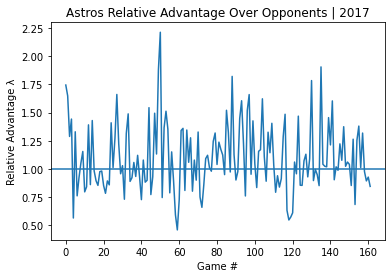

Lambda mean: 1.0997526748655129


In [22]:
plt.plot(lambda_s_2017)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Astros Relative Advantage Over Opponents | 2017")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_2017))

As we can see, the advantage varies significantly. This can be attributed to the home vs. away game differences has on ERA, which is variable in this volatility.

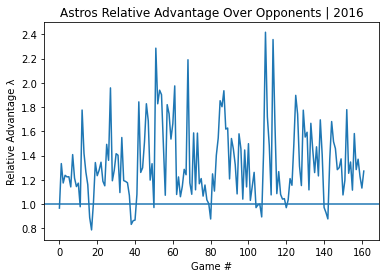

Lambda mean: 1.3402790442547716


In [23]:
plt.plot(lambda_s_2016)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Astros Relative Advantage Over Opponents | 2016")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_2016))

2016 looks entierly different than 2017. While there still remains the volatility, The beginning of the season looks weaker when compared to 2017. Even through mean for 2016 is greater than the mean for 2017 (1.16 > 1.329), the Win-loss percentage is lower than it was in 2017, about a 10% difference (0.519 to 0.623).

Let's try another team. The Boston Red Sox

In [24]:
# Getting appropriate stats and cleaning
BOS_2017 = schedule_and_record(2017, "BOS")

BOS_2017 = BOS_2017[['Home_Away', 'Opp', 'W/L']] # Getting only necessary columns.

BOS_2017.loc[BOS_2017['Home_Away'] == 'Home', 'is_home'] = 1 # Bool as to whether the team plays home or away
BOS_2017.loc[BOS_2017['Home_Away'] != 'Home', 'is_home'] = 0
is_home_BOS_2017 = BOS_2017['is_home'].values

BOS_2017['Opp'].replace(tm_abv, idx, inplace=True) # Replacing team abreveations as numbers

lambda_s_BOS_2017 = Initialize_Variables(data = data_2017, team = 3, game_opponents = BOS_2017['Opp'], is_home = is_home_BOS_2017)

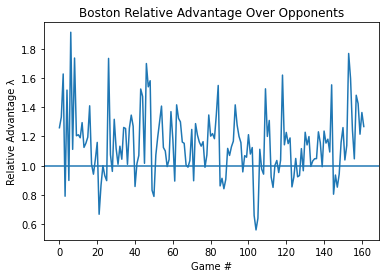

Lambda mean: 1.1480976472512463


In [25]:
plt.plot(lambda_s_BOS_2017)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Boston Relative Advantage Over Opponents")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_BOS_2017))

The Red Sox usually has an advantage over other teams. This makes sense when in context of their performance as they are high performers, and have one the World Series twice in the past couple of years, 2018 and 2013.

The Detroit Tigers where had one of the lowest Win/Loss Percentages. Let's look at their advantage.

In [26]:
DET_2017 = schedule_and_record(2017, "DET")

DET_2017 = DET_2017[['Home_Away', 'Opp', 'W/L']] # Getting only necessary columns.

DET_2017.loc[BOS_2017['Home_Away'] == 'Home', 'is_home'] = 1 # Bool as to whether the team plays home or away
DET_2017.loc[BOS_2017['Home_Away'] != 'Home', 'is_home'] = 0
is_home_DET_2017 = BOS_2017['is_home'].values

DET_2017['Opp'].replace(tm_abv, idx, inplace=True) # Replacing team abreveations as numbers

lambda_s_DET_2017 = Initialize_Variables(data = data_2017, team = 9, game_opponents = DET_2017['Opp'], is_home = is_home_DET_2017)

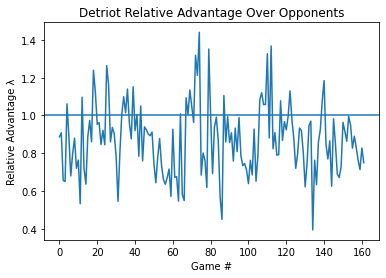

Lambda mean: 0.8722032372032814


In [39]:
plt.plot(lambda_s_DET_2017)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Detriot Relative Advantage Over Opponents")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_DET_2017))

As you can see, their AoP is nearly always less than 1 barring some instances.

### Astros λ Predicted

While lambda is not part of the model, we find that it is still important to ask the question as to whether the Sign-Stealing-Scandal helped them. Although we are unable to directly create a test which tests that, we are under the assumption that sign stealing did help their statistics. Therefore, we propose a hypothesis test where the null-hypothesis $H_0$ is that difference between the 2017 predicted advantages and the 2017 actual advantages is not significant such that $p > 0.01$. The alternative hypothesis $H_1$ is that difference is significant and that $p < 0.01$.

In [28]:
pred = [3.247, 4.87, 0.4947, 0.2513] # Astros 2017 predicted values with simple linear regression
act = [3.65, 4.61, 0.395, 0.282]
data_2017.loc[10].replace(act, pred)

lambda_s_2017_pred = Initialize_Variables(data = data_2017, team = 10, game_opponents = HOU_2017['Opp'], is_home = is_home_2017)


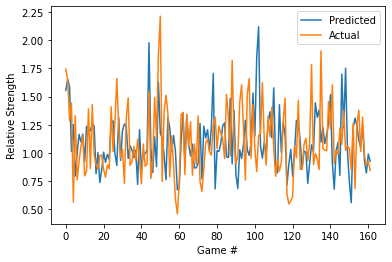

Lambda mean predicted: 1.1028281907802906
Lambda mean actual: 1.0997526748655129


In [29]:
plt.plot(lambda_s_2017_pred, label= "Predicted")
plt.plot(lambda_s_2017, label = "Actual")
plt.xlabel("Game #")
plt.ylabel("Relative Strength")
plt.legend()
plt.show()

print("Lambda mean predicted:", statistics.mean(lambda_s_2017_pred))
print("Lambda mean actual:", statistics.mean(lambda_s_2017))

In [30]:
# Mann-Whitney Test
p = sc.stats.mannwhitneyu(lambda_s_2017, lambda_s_2017_pred)
print("Mann-Whitney P-Score:", p[1])

Mann-Whitney P-Score: 0.30314534974221263


As $p > 0.01$, $p = 0.30314$, we are unable to reject the null-hypothesis and are able to determine that the stats the Astros produced in the 2017 season is very likely to occur again, given the same performance at that time.

## Predictive Modeling

$$p_s \sim beta(m\lambda\delta,m)$$
$$X_t \sim Bernoulli(p_s)$$

In [31]:
def predict(lambda_s, m, delta):
    p_t = []
    for lambda_t in lambda_s:
        alpha = lambda_t * m * delta
        p_t.append(sc.stats.beta.mean(alpha, m))
    X_t = []
    for p_s in p_t:
        X_t.append(sc.stats.bernoulli.mean(p_s))
    return X_t

Predicting Winners

In [32]:
delta = sc.stats.uniform.mean(0, 2)
m = sc.stats.expon.mean(10)
pred_act = predict(lambda_s = lambda_s_2017, m = m, delta = delta)

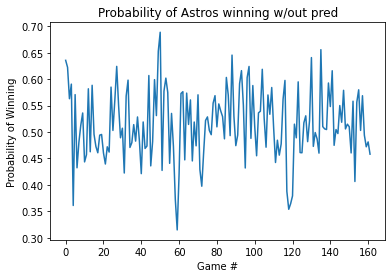

In [33]:
plt.plot(pred_act)
plt.xlabel("Game #")
plt.ylabel("Probability of Winning")

plt.title("Probability of Astros winning w/out pred")
plt.show()

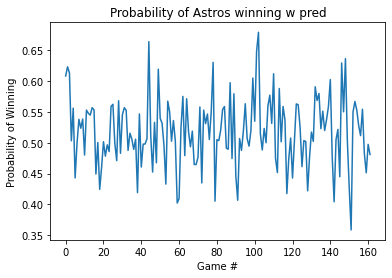

In [34]:
delta = sc.stats.uniform.mean(0, 2)
m = sc.stats.expon.mean(10)
pred_pred = predict(lambda_s = lambda_s_2017_pred, m = m, delta = delta)
plt.plot(pred_pred)
plt.xlabel("Game #")
plt.ylabel("Probability of Winning")

plt.title("Probability of Astros winning w pred")
plt.show()

In [35]:
HOU_2017['Pred_Wins'] = pred_act

HOU_2017.loc[HOU_2017['Pred_Wins'] > 0.50, 'Pred_Wins_Letter'] = 'W'
HOU_2017.loc[HOU_2017['Pred_Wins'] <= 0.50, 'Pred_Wins_Letter'] = 'L'

HOU_2017['Pred_Accur'] = np.where(HOU_2017['W/L'] == HOU_2017['Pred_Wins_Letter'], 1, 0)

print("Guessed Correctly:", HOU_2017['Pred_Accur'].sum()/162)

Guessed Correctly: 0.5555555555555556


### Mann-Whitney Test

In [36]:
# Mann-Whitney Test
p = sc.stats.mannwhitneyu(pred_pred, pred_act)
print("Mann-Whitney P-Score:", p[1])

Mann-Whitney P-Score: 0.30314534974221263


Predicting for other Teams

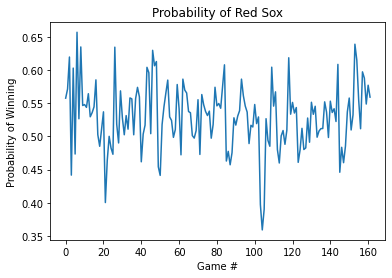

Guessed Correctly: 0.4691358024691358


In [37]:
delta = sc.stats.uniform.mean(0, 2)
m = sc.stats.expon.mean(10)
pred_bos_2017 = predict(lambda_s = lambda_s_BOS_2017, m = m, delta = delta)
plt.plot(pred_bos_2017)
plt.xlabel("Game #")
plt.ylabel("Probability of Winning")

plt.title("Probability of Red Sox")
plt.show()

BOS_2017['Pred_Wins'] = pred_act

BOS_2017.loc[BOS_2017['Pred_Wins'] > 0.50, 'Pred_Wins_Letter'] = 'W'
BOS_2017.loc[BOS_2017['Pred_Wins'] <= 0.50, 'Pred_Wins_Letter'] = 'L'

BOS_2017['Pred_Accur'] = np.where(BOS_2017['W/L'] == BOS_2017['Pred_Wins_Letter'], 1, 0)

print("Guessed Correctly:", BOS_2017['Pred_Accur'].sum()/162)

# Key Takeaway

1. We are unable to reject the null hypothesis that better stats caused by sign-stealing improved their chances of winning.

# Room for Improvement

1. Get better predicted values using modeling and gibbs sampling, rather than linear regression basic distributions.
2. Use a different model.